In [31]:
import os
# import re

import pandas as pd
# import skimage as ski
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

# tf.test.is_gpu_available()

In [2]:
def path(text):
    return os.path.join(*text.split("/"))

def annotate(ax):
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() / 2 - 1),
                    ha='center', va='bottom', bbox={'color': 'white'})

# Parameters

In [32]:
DATASET_PATH = path("../dataset.csv")
KS_IMAGES_PATH = path("../../../ksc-data/images")
FEATURES_PATH = path("../features/old.vgg19.npy")

SEED = 42
NKFOLD = 10
TRAIN_TEST_SPLIT_SIZE = 0.7
CLASSES = ['Ia', 'IIb', 'IIIb']
# CLASSES = None
WITH_OTHER = True  # If True, kidney stones which don't fall into preceding 'CLASSES' will be put in an 'Other' class

BATCH_SIZE = 64

# Dataset loading

In [4]:
df = pd.read_csv(DATASET_PATH)

In [5]:
POTENTIAL_CLASSES = df.stone_class.unique().tolist()
if CLASSES is None:
    CLASSES = POTENTIAL_CLASSES
    WITH_OTHER = False
    
LABELS = list(CLASSES)
if WITH_OTHER and not (CLASSES == POTENTIAL_CLASSES):
    LABELS += ['Other']

In [6]:
df['type_image'] = df.SEC.map(lambda x: 'SEC' if x else 'SUR')

In [7]:
df.head()

,filename,stone_class,class_level_1,class_level_2,filetype,SUR,SEC,type_image
0,Ia_SEC_1.jpg,Ia,I,a,jpg,False,True,SEC
1,Ia_SEC_10.jpg,Ia,I,a,jpg,False,True,SEC
2,Ia_SEC_11.jpg,Ia,I,a,jpg,False,True,SEC
3,Ia_SEC_12.jpg,Ia,I,a,jpg,False,True,SEC
4,Ia_SEC_13.jpg,Ia,I,a,jpg,False,True,SEC


In [8]:
filtered_df = df

In [9]:
rng = np.random.default_rng(SEED)
indices = filtered_df.index.values
rng.shuffle(indices)

In [10]:
features = np.load(FEATURES_PATH)
features.shape

(203, 4, 7, 7, 512)

In [11]:
X = features[indices]

In [12]:
def classes_mapper(y):
    try:
        return CLASSES.index(y)
    except Exception as e:
        if WITH_OTHER:
            return len(CLASSES)
        raise e

In [13]:
def inverse_class_mapper(pred):
    return (CLASSES + ['Other'] if WITH_OTHER else CLASSES)[pred]

In [14]:
shuffled_df = pd.DataFrame(filtered_df.iloc[indices])

In [15]:
shuffled_df['class_number'] = shuffled_df.stone_class.map(classes_mapper)

In [98]:
shuffled_df.groupby('class_number').count().filename

class_number
0    54
1    28
2    32
3    89
Name: filename, dtype: int64

In [16]:
Y = shuffled_df.class_number.values

In [17]:
print(Y)

[3 0 3 0 0 0 3 3 3 3 0 3 1 0 2 3 3 0 3 0 2 3 3 2 3 1 0 3 3 3 3 3 3 0 0 1 3
 2 3 1 3 0 0 0 3 3 1 0 3 1 1 1 1 0 2 2 3 1 0 1 0 0 2 3 3 1 3 3 0 0 3 0 3 2
 0 3 1 3 3 3 0 2 3 3 0 3 2 0 1 2 0 3 2 3 2 3 2 2 1 3 3 1 0 1 1 3 0 3 3 2 2
 3 3 3 3 1 1 3 2 0 2 1 1 1 3 3 3 3 1 3 3 3 2 3 2 3 2 0 2 2 3 0 0 2 0 3 0 3
 3 0 3 3 2 3 1 3 0 2 0 3 3 3 3 3 0 3 3 0 3 1 2 0 0 0 3 0 0 3 0 3 0 0 1 3 2
 3 0 3 0 0 3 3 0 3 2 3 0 2 3 0 1 3 2]


# Dataset spliting

In [43]:
skf = StratifiedKFold(n_splits=NKFOLD)

In [94]:
train_indices, test_indices = next(skf.split(np.zeros(Y.shape), Y))

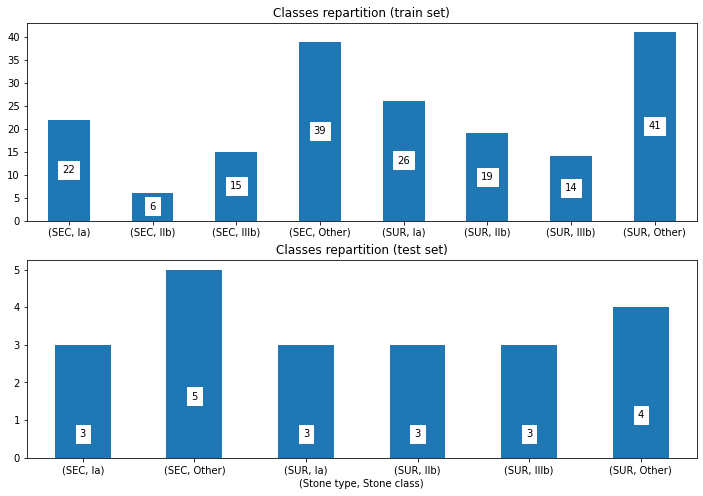

In [48]:
fig, axes = plt.subplots(figsize=(12, 8), nrows=2)
shuffled_df.iloc[train_indices].groupby(['type_image', 'class_number'])\
.count().stone_class.rename({i: v for i, v in enumerate(LABELS)})\
.plot.bar(title='Classes repartition (train set)', rot=0, xlabel='', ax=axes[0]);
annotate(axes[0])

shuffled_df.iloc[test_indices].groupby(['type_image', 'class_number'])\
.count().stone_class.rename({i: v for i, v in enumerate(LABELS)})\
.plot.bar(title='Classes repartition (test set)', rot=0, xlabel='(Stone type, Stone class)', ax=axes[1]);
annotate(axes[1])

In [26]:
fig.savefig(f'dataset_repartition.png')

In [49]:
X_train = X[train_indices]
Y_train = Y[train_indices]

Y_train = np.reshape(Y_train, (Y_train.shape[0], -1))
Y_train = np.repeat(Y_train, X_train.shape[1], axis=-1)
Y_train = np.reshape(Y_train, (-1,))
print(f"Y_train.shape = {Y_train.shape}")

X_train = np.reshape(X_train, (-1,) + X_train.shape[2:])
X_train = np.reshape(X_train, (X_train.shape[0], -1))
print(f"X_train.shape = {X_train.shape}")

Y_train.shape = (728,)
X_train.shape = (728, 25088)


In [50]:
X_test = X[test_indices]
Y_test = Y[test_indices]

X_test = X_test[:, 0, ...]
X_test = np.reshape(X_test, (-1,) + X_test.shape[1:])
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(f"X_test.shape = {X_test.shape}")

print(f"Y_test.shape = {Y_test.shape}")

X_test.shape = (21, 25088)
Y_test.shape = (21,)


# Model creation

In [51]:
hidden_layers = (500,)
nb_classes = len(LABELS)

In [52]:
classifier = MLPClassifier(hidden_layers, batch_size=BATCH_SIZE, verbose=True, random_state=SEED, early_stopping=True)

In [53]:
classifier.fit(X_train, Y_train)

Iteration 1, loss = 6.12181278
Validation score: 0.876712
Iteration 2, loss = 1.03304520
Validation score: 0.917808
Iteration 3, loss = 0.25500074
Validation score: 0.917808
Iteration 4, loss = 0.13005135
Validation score: 0.945205
Iteration 5, loss = 0.03263807
Validation score: 0.945205
Iteration 6, loss = 0.00101617
Validation score: 0.958904
Iteration 7, loss = 0.00104374
Validation score: 0.958904
Iteration 8, loss = 0.00104749
Validation score: 0.972603
Iteration 9, loss = 0.00102016
Validation score: 0.958904
Iteration 10, loss = 0.00101566
Validation score: 0.958904
Iteration 11, loss = 0.00101471
Validation score: 0.958904
Iteration 12, loss = 0.00101386
Validation score: 0.958904
Iteration 13, loss = 0.00101335
Validation score: 0.958904
Iteration 14, loss = 0.00101293
Validation score: 0.958904
Iteration 15, loss = 0.00101253
Validation score: 0.958904
Iteration 16, loss = 0.00101215
Validation score: 0.958904
Iteration 17, loss = 0.00101180
Validation score: 0.958904
Iterat

MLPClassifier(batch_size=64, early_stopping=True, hidden_layer_sizes=(500,),
              random_state=42, verbose=True)

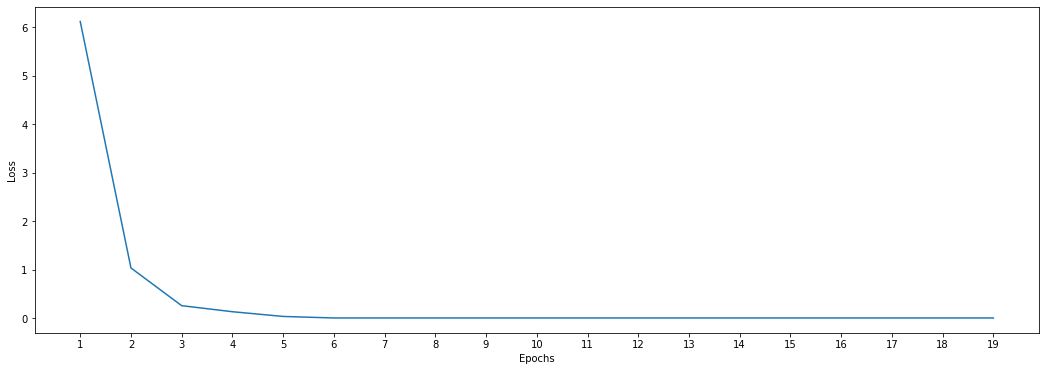

In [54]:
plt.figure(figsize=(18,6))
xticks = np.arange(classifier.n_iter_) + 1
plt.plot(xticks, classifier.loss_curve_);
# plt.yscale('log');
plt.xticks(xticks);
plt.xlabel('Epochs');
plt.ylabel('Loss');

In [55]:
classifier.score(X_test, Y_test)

0.9523809523809523

# Test model performances

In [56]:
Y_pred = classifier.predict(X_test)

In [57]:
print(classification_report(Y_test, Y_pred, labels=classifier.classes_, target_names=LABELS))

              precision    recall  f1-score   support

          Ia       1.00      1.00      1.00         6
         IIb       1.00      1.00      1.00         3
        IIIb       1.00      0.67      0.80         3
       Other       0.90      1.00      0.95         9

    accuracy                           0.95        21
   macro avg       0.97      0.92      0.94        21
weighted avg       0.96      0.95      0.95        21



In [58]:
classification_report_dict = classification_report(Y_test, Y_pred, labels=classifier.classes_, target_names=LABELS, output_dict=True)

In [60]:
pd.DataFrame(classification_report_dict).to_csv()

,Ia,IIb,IIIb,Other,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.000000,0.900000,0.952381,0.975000,0.957143
recall,1.0,1.0,0.666667,1.000000,0.952381,0.916667,0.952381
f1-score,1.0,1.0,0.800000,0.947368,0.952381,0.936842,0.948872
support,6.0,3.0,3.000000,9.000000,0.952381,21.000000,21.000000


In [61]:
test_df = pd.DataFrame(shuffled_df.iloc[test_indices])

In [62]:
test_df['y_pred'] = list(map(inverse_class_mapper, Y_pred))
test_df['y_true'] = list(map(inverse_class_mapper, Y_test))

In [63]:
test_df['correct'] = (Y_pred == Y_test).astype('int32')

In [64]:
test_df

,filename,stone_class,class_level_1,class_level_2,filetype,SUR,SEC,type_image,class_number,y_pred,y_true,correct
155,IVa1_SUR_2.png,IVa1,IV,a1,png,True,False,SUR,3,Other,Other,1
25,Ia_SUR_10.jpg,Ia,I,a,jpg,True,False,SUR,0,Ia,Ia,1
136,VIa_SUR_4.png,VIa,VI,a,png,True,False,SUR,3,Other,Other,1
101,Ia_SUR_29.jpg,Ia,I,a,jpg,True,False,SUR,0,Ia,Ia,1
179,Ia_SUR_21.jpg,Ia,I,a,jpg,True,False,SUR,0,Ia,Ia,1
114,Ia_SEC_16.jpg,Ia,I,a,jpg,False,True,SEC,0,Ia,Ia,1
80,IIa_SEC_2.png,IIa,II,a,png,False,True,SEC,3,Other,Other,1
111,IIIa_SUR_2.png,IIIa,III,a,png,True,False,SUR,3,Other,Other,1
40,IVa1_SEC_2.png,IVa1,IV,a1,png,False,True,SEC,3,Other,Other,1
178,Ib_SEC_3.png,Ib,I,b,png,False,True,SEC,3,Other,Other,1


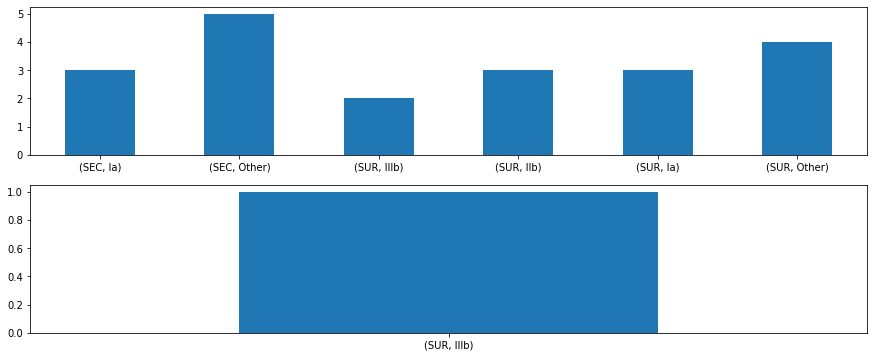

In [83]:
fig, axes = plt.subplots(figsize=(15,6), nrows=2)
test_df[test_df.correct == 1].groupby(['type_image', 'y_true']).count().filename.plot.bar(rot=0, ax=axes[0], xlabel='', title='');
test_df[test_df.correct == 0].groupby(['type_image', 'y_true']).count().filename.plot.bar(rot=0, ax=axes[1], xlabel='', title='');

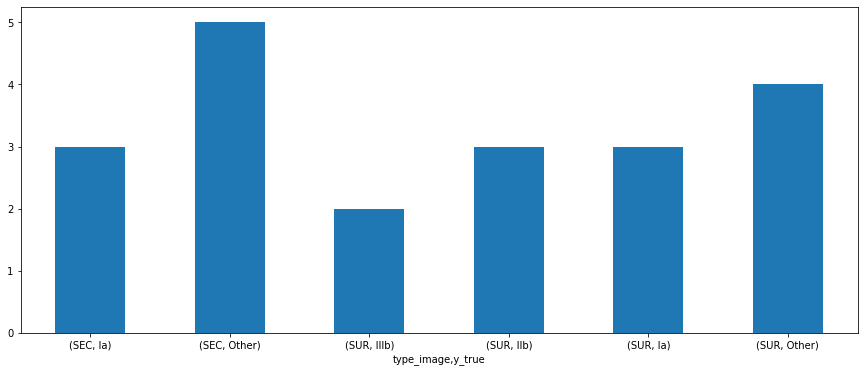

In [82]:
fig.savefig('')

In [85]:
import datetime

In [92]:
datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

'2021-05-26_15-08-06'